In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
data = pd.read_csv("../data/curated/listings_with_distances.csv")
school = pd.read_csv("../data/curated/Closest_and_average_dist_school.csv")

In [12]:
data = pd.merge(data,school,left_on='id',right_on='listing_id')

In [25]:
COLS = ["price", "beds","propertyType", "dist_closest_school","ave_dist_3_schools", "ClosestDstToShoppingCentre", "DstToCBD", "ClosestShop", "ClosestDstToStation", "ClosestStation", "ClosestDstToUni", "ClosestUni"]
CORR_COLS = ["price", "ClosestDstToShoppingCentre", "DstToCBD", "ClosestDstToStation", "ClosestDstToUni", "dist_closest_school","ave_dist_3_schools"]

In [67]:
data = data[COLS]
data.loc[data['ClosestDstToShoppingCentre'] == 100000, ['ClosestDstToShoppingCentre']] = None
data.loc[data['ClosestDstToStation'] == 100000, ['ClosestDstToStation']] = None
data.loc[data['DstToCBD'] == 100000, ['DstToCBD']] = None
data.loc[data['ClosestDstToUni'] == 100000, ['ClosestDstToUni']] = None


In [69]:
bed_4_house = data[(data["beds"] == 4) & (data["propertyType"] == "House")]
bed_3_house = data[(data["beds"] == 3) & (data["propertyType"] == "House")]
bed_2_house = data[(data["beds"] == 2) & (data["propertyType"] == "House")]
bed_3_flat = data[(data["beds"] == 3) & (data["propertyType"] == "Apartment / Unit / Flat")]
bed_2_flat = data[(data["beds"] == 2) & (data["propertyType"] == "Apartment / Unit / Flat")]
bed_1_flat = data[(data["beds"] == 1) & (data["propertyType"] == "Apartment / Unit / Flat")]

In [70]:
bed_4_house[CORR_COLS].corr()
#sns.heatmap(bed_4_house[CORR_COLS].corr())


,price,ClosestDstToShoppingCentre,DstToCBD,ClosestDstToStation,ClosestDstToUni,dist_closest_school,ave_dist_3_schools
price,1.000000,0.008587,-0.245481,-0.044525,-0.070226,-0.125836,-0.117769
ClosestDstToShoppingCentre,0.008587,1.000000,0.552069,0.554488,0.616743,0.283587,0.424668
DstToCBD,-0.245481,0.552069,1.000000,0.517806,0.578902,0.269638,0.398440
ClosestDstToStation,-0.044525,0.554488,0.517806,1.000000,0.420882,0.344277,0.478754
ClosestDstToUni,-0.070226,0.616743,0.578902,0.420882,1.000000,0.264952,0.357733
dist_closest_school,-0.125836,0.283587,0.269638,0.344277,0.264952,1.000000,0.701546
ave_dist_3_schools,-0.117769,0.424668,0.398440,0.478754,0.357733,0.701546,1.000000


In [71]:
bed_3_house[CORR_COLS].corr()
#sns.heatmap(bed_3_house[CORR_COLS].corr())

,price,ClosestDstToShoppingCentre,DstToCBD,ClosestDstToStation,ClosestDstToUni,dist_closest_school,ave_dist_3_schools
price,1.000000,-0.072678,-0.234968,-0.062171,-0.096503,-0.070351,-0.078624
ClosestDstToShoppingCentre,-0.072678,1.000000,0.531547,0.663131,0.656973,0.298297,0.450834
DstToCBD,-0.234968,0.531547,1.000000,0.590293,0.660506,0.336812,0.474753
ClosestDstToStation,-0.062171,0.663131,0.590293,1.000000,0.586158,0.338701,0.494777
ClosestDstToUni,-0.096503,0.656973,0.660506,0.586158,1.000000,0.350833,0.409455
dist_closest_school,-0.070351,0.298297,0.336812,0.338701,0.350833,1.000000,0.748415
ave_dist_3_schools,-0.078624,0.450834,0.474753,0.494777,0.409455,0.748415,1.000000


In [72]:
bed_2_house[CORR_COLS].corr()
#sns.heatmap(bed_2_house[CORR_COLS].corr())

,price,ClosestDstToShoppingCentre,DstToCBD,ClosestDstToStation,ClosestDstToUni,dist_closest_school,ave_dist_3_schools
price,1.000000,-0.217006,-0.386277,-0.165941,-0.228408,-0.150794,-0.142424
ClosestDstToShoppingCentre,-0.217006,1.000000,0.519760,0.723366,0.744606,0.263586,0.437175
DstToCBD,-0.386277,0.519760,1.000000,0.569206,0.654504,0.274600,0.507030
ClosestDstToStation,-0.165941,0.723366,0.569206,1.000000,0.652255,0.342391,0.493986
ClosestDstToUni,-0.228408,0.744606,0.654504,0.652255,1.000000,0.302131,0.489098
dist_closest_school,-0.150794,0.263586,0.274600,0.342391,0.302131,1.000000,0.512396
ave_dist_3_schools,-0.142424,0.437175,0.507030,0.493986,0.489098,0.512396,1.000000


In [73]:
bed_3_flat[CORR_COLS].corr()
#sns.heatmap(bed_3_flat[CORR_COLS].corr())

,price,ClosestDstToShoppingCentre,DstToCBD,ClosestDstToStation,ClosestDstToUni,dist_closest_school,ave_dist_3_schools
price,1.000000,-0.132248,-0.361544,-0.088552,-0.225886,-0.046727,-0.073292
ClosestDstToShoppingCentre,-0.132248,1.000000,0.476873,0.499167,0.733950,0.186626,0.229378
DstToCBD,-0.361544,0.476873,1.000000,0.423415,0.664736,0.165167,0.383173
ClosestDstToStation,-0.088552,0.499167,0.423415,1.000000,0.412226,0.188583,0.255524
ClosestDstToUni,-0.225886,0.733950,0.664736,0.412226,1.000000,0.141840,0.205055
dist_closest_school,-0.046727,0.186626,0.165167,0.188583,0.141840,1.000000,0.892861
ave_dist_3_schools,-0.073292,0.229378,0.383173,0.255524,0.205055,0.892861,1.000000


In [74]:
bed_2_flat[CORR_COLS].corr()
#sns.heatmap(bed_2_flat[CORR_COLS].corr())

,price,ClosestDstToShoppingCentre,DstToCBD,ClosestDstToStation,ClosestDstToUni,dist_closest_school,ave_dist_3_schools
price,1.000000,-0.072622,-0.308748,-0.094828,-0.182994,-0.129227,-0.101114
ClosestDstToShoppingCentre,-0.072622,1.000000,0.491810,0.725003,0.693237,0.132433,0.276448
DstToCBD,-0.308748,0.491810,1.000000,0.486684,0.696468,0.232521,0.449911
ClosestDstToStation,-0.094828,0.725003,0.486684,1.000000,0.554950,0.124442,0.308335
ClosestDstToUni,-0.182994,0.693237,0.696468,0.554950,1.000000,0.197206,0.351783
dist_closest_school,-0.129227,0.132433,0.232521,0.124442,0.197206,1.000000,0.468473
ave_dist_3_schools,-0.101114,0.276448,0.449911,0.308335,0.351783,0.468473,1.000000


In [75]:
bed_1_flat[CORR_COLS].corr()
#sns.heatmap(bed_1_flat[CORR_COLS].corr())

,price,ClosestDstToShoppingCentre,DstToCBD,ClosestDstToStation,ClosestDstToUni,dist_closest_school,ave_dist_3_schools
price,1.000000,-0.043467,-0.215837,-0.101675,-0.112534,-0.044029,-0.073791
ClosestDstToShoppingCentre,-0.043467,1.000000,0.458500,0.716311,0.661418,0.159680,0.339639
DstToCBD,-0.215837,0.458500,1.000000,0.490033,0.624823,0.177844,0.340200
ClosestDstToStation,-0.101675,0.716311,0.490033,1.000000,0.520430,0.086273,0.299547
ClosestDstToUni,-0.112534,0.661418,0.624823,0.520430,1.000000,0.226831,0.347362
dist_closest_school,-0.044029,0.159680,0.177844,0.086273,0.226831,1.000000,0.660080
ave_dist_3_schools,-0.073791,0.339639,0.340200,0.299547,0.347362,0.660080,1.000000


(0.0, 3000.0)

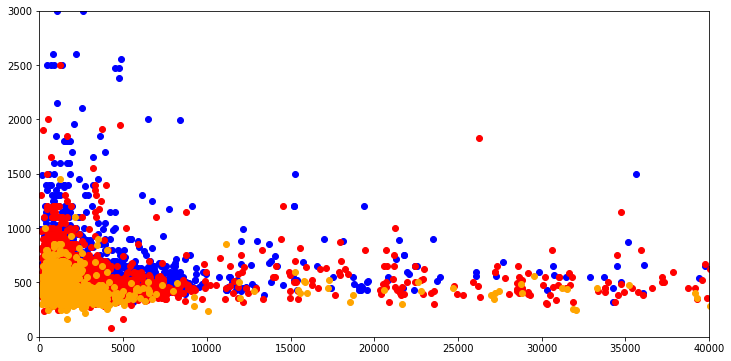

In [92]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter("ClosestDstToStation", "price", color="blue", data=bed_4_house)
ax.scatter("ClosestDstToStation", "price", color="red", data=bed_3_house)
ax.scatter("ClosestDstToStation", "price", color="orange", data=bed_2_house)
plt.xlim(0, 40000)
plt.ylim(0, 3000)

(0.0, 2000.0)

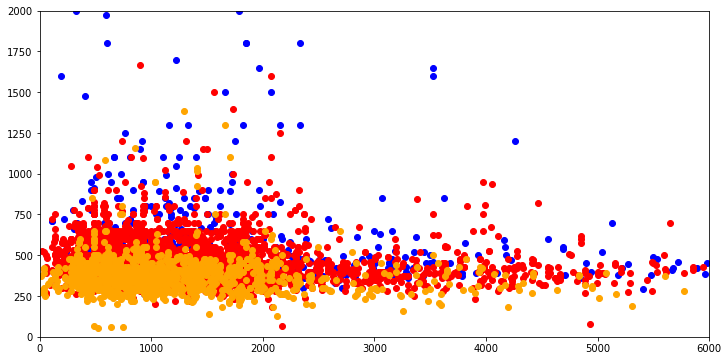

In [99]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter("ClosestDstToStation", "price", color="blue", data=bed_3_flat)
ax.scatter("ClosestDstToStation", "price", color="red", data=bed_2_flat)
ax.scatter("ClosestDstToStation", "price", color="orange", data=bed_1_flat)
plt.xlim(0, 6000)
plt.ylim(0, 2000)

(0.0, 3000.0)

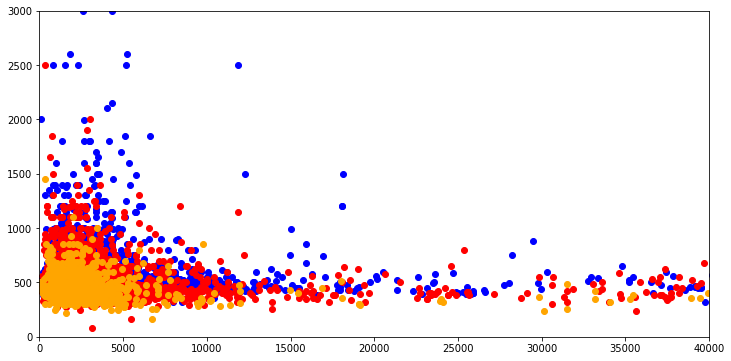

In [100]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter("ClosestDstToShoppingCentre", "price", color="blue", data=bed_4_house)
ax.scatter("ClosestDstToShoppingCentre", "price", color="red", data=bed_3_house)
ax.scatter("ClosestDstToShoppingCentre", "price", color="orange", data=bed_2_house)
plt.xlim(0, 40000)
plt.ylim(0, 3000)

(0.0, 3000.0)

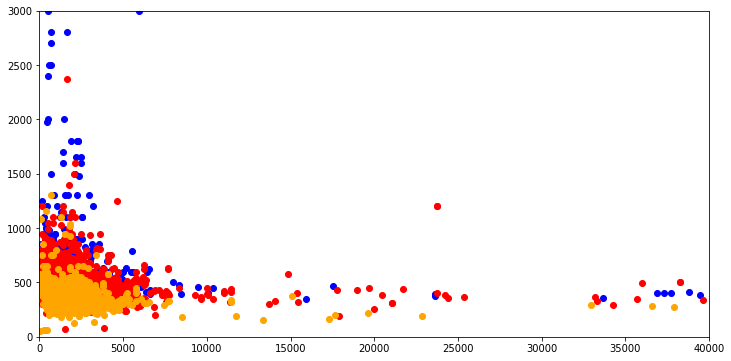

In [102]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter("ClosestDstToShoppingCentre", "price", color="blue", data=bed_3_flat)
ax.scatter("ClosestDstToShoppingCentre", "price", color="red", data=bed_2_flat)
ax.scatter("ClosestDstToShoppingCentre", "price", color="orange", data=bed_1_flat)
plt.xlim(0, 40000)
plt.ylim(0, 3000)